In [88]:
import pandas as pd
import random
import os
import numpy as np
from project import *
import seqlogo
import timeit
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
# This was used to perform some minor cleaning on data from the original data from the paper
#df = pd.read_excel("motif_data.xlsx" ,engine='openpyxl',header=2,usecols=range(0,9))
# df.to_csv("motif_clean.csv",index=False)

In [4]:
#Read In Data
df = pd.read_csv("motif_clean.csv",index_col=False)
#Rename column to shorter name
df.rename(columns={'DNAseq (+/- 50nts from peak center)':'Seq'}, inplace=True)

In [5]:
#What does the data look like?
df.head()

,Regulator,Gene,p-Value,Score,VPM,Peak Start (Fstart),Peak Stop (Rstop),Peak Center (Ccenter),Seq
0,Rv0020c,Rv0020c,0.008387,0.708045,747,24834,25442,25262.0,CGACTGGATGCCGTCGGCCGCCTCGCGGCGCAGCAGGGCTTCGACC...
1,Rv0022c,MT0031,0.000000,0.938136,371,31853,32123,31964.0,TTCTCGCGCTCGAGTGAGCAGAGCCCGCACCTCGTCGAGTTGCTGC...
2,Rv0022c,MT0124,0.006907,0.747817,42,139867,140092,139961.0,AATGACGCACGCTGATCGGGCTTCCTGCAGGAGAAGAACATGACCA...
3,Rv0022c,MT0407.1,0.002960,0.837341,42,476142,476370,476251.0,CCGGTAGGCGCCTGCCCAAAACACGGGTATTGGGTAAAGGCACGGG...
4,Rv0022c,MT1759,0.008387,0.710485,22,1946282,1946498,1946420.0,CGCGTGGTTCAACGGCACTGAGGATCGCAAATGACAGAAGCGTTGT...


In [6]:
cleanSeqs = clean_strings(df["Seq"].tolist())
zero_order_freq = zero_order_freq(cleanSeqs)
first_order_freq = first_order_freq(cleanSeqs)

In [56]:
def run_gibbs(seqs,k=9,back=None):
    return GibbsSampler(seqs,k=k,numSeq=len(seqs),seqLen=len(seqs[0]),itr=3000,background=back)
def get_ppm(mtrx):
    return seqlogo.Ppm(mtrx.T)
def get_logo(ppm):
    return seqlogo.seqlogo(ppm, ic_scale = False, format = 'png', size = 'medium')

In [33]:
def get_pwm():
    reg_groups = df.groupby("Regulator")["Seq"]
    regulators = [k for k,v in reg_groups if len(v) > 50]
    print("Creating PWMs for ",str(len(regulators))," regulators with lengths greater than 50")
    dct = {}
    for reg,n in zip(regulators,range(len(regulators))):
        print("Creating for ",str(reg)," ,number : ",str(n)," num seq : ",len(reg_groups.get_group(reg)))
        cleanseq = clean_strings(reg_groups.get_group(reg).tolist())
        zr = get_background(cleanseq,9,zero_order_freq,0)
        fs = get_background(cleanseq,9,first_order_freq,1)
        dct[reg] = {
            "no_bg" : run_gibbs(cleanseq,back=None),
            "zero_bg" : run_gibbs(cleanseq,back=zr),
            "one_bg" : run_gibbs(cleanseq,back=fs)
        }
    return dct

In [34]:
res = get_pwm()

Creating PWMs for  51  with lengths greater than 50
Creating for  Rv0022c  ,number :  0  num seq :  218
Creating for  Rv0023  ,number :  1  num seq :  347
Creating for  Rv0047c  ,number :  2  num seq :  634
Creating for  Rv0081  ,number :  3  num seq :  856
Creating for  Rv0135c  ,number :  4  num seq :  439
Creating for  Rv0273c  ,number :  5  num seq :  80
Creating for  Rv0302  ,number :  6  num seq :  285
Creating for  Rv0324  ,number :  7  num seq :  437
Creating for  Rv0465c  ,number :  8  num seq :  132
Creating for  Rv0494  ,number :  9  num seq :  77
Creating for  Rv0602c  ,number :  10  num seq :  131
Creating for  Rv0653c  ,number :  11  num seq :  60
Creating for  Rv0678  ,number :  12  num seq :  739
Creating for  Rv0691c  ,number :  13  num seq :  412
Creating for  Rv0757  ,number :  14  num seq :  149
Creating for  Rv0767c  ,number :  15  num seq :  238
Creating for  Rv0967  ,number :  16  num seq :  859
Creating for  Rv1033c  ,number :  17  num seq :  546
Creating for  R

In [35]:
reg_groups = df.groupby("Regulator")["Seq"]
regulators = [k for k,v in reg_groups if len(v) > 50]

In [47]:
for key in res:
    for or_key in res[key]:
        res[key][or_key] = get_ppm(res[key][or_key])

In [75]:
#reg = "Rv0022c"
reg = "Rv2009"

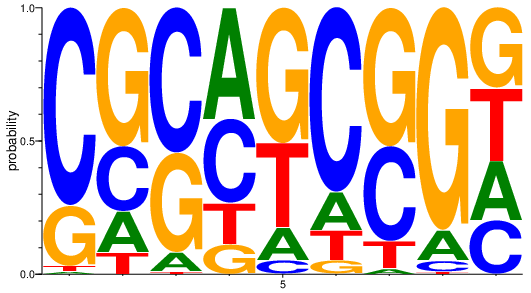

In [76]:
get_logo(res[reg]["no_bg"])

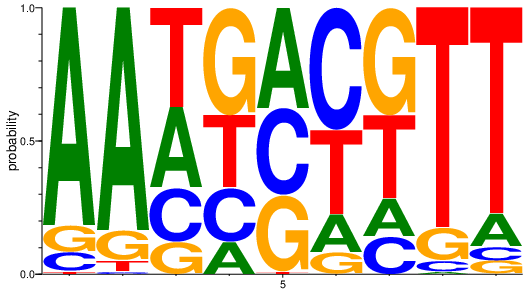

In [77]:
get_logo(res[reg]["zero_bg"])

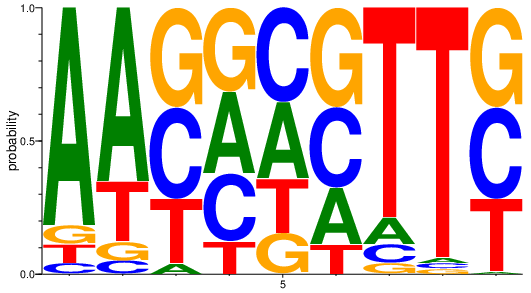

In [78]:
get_logo(res[reg]["one_bg"])

In [125]:
no_bg = []
zero_bg = []
one_bg = []
for key in res:
    no_bg.append(sum(res[key]["no_bg"].ic))
    zero_bg.append(sum(res[key]["zero_bg"].ic))
    one_bg.append(sum(res[key]["one_bg"].ic))
no_bg = np.array(no_bg)
zero_bg = np.array(zero_bg)
one_bg = np.array(one_bg)

In [126]:
means = [no_bg.mean(),zero_bg.mean(),one_bg.mean()]
errors = [no_bg.std(),zero_bg.std(),one_bg.std()]
labels = ["No BG","Zero BG","One BG"]
x_pos = np.arange(len(labels))

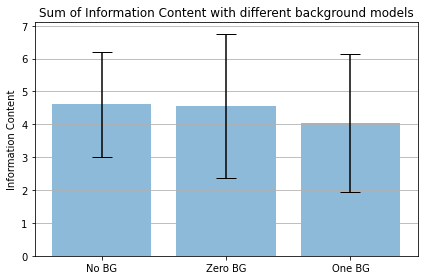

In [130]:
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=errors, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Information Content')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Sum of Information Content with different background models')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Paper/Pictures/ic_content.png')
plt.show()

<Figure size 432x288 with 0 Axes>